In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [13]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [15]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [16]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [17]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [18]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [ ]:
def build_1d_cnn_custom_ch_32_BN_2(conv_num=1):
    kernel_size = 64
    filter_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [ ]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
max_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_39 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_40 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1087 - acc: 0.4218
Epoch 00001: val_loss improved from inf to 1.76478, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_3_conv_checkpoint/001-1.7648.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 2.1088 - acc: 0.4218 - val_loss: 1.7648 - val_acc: 0.4743
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3104 - acc: 0.6270
Epoch 00002: val_loss did not improve from 1.76478
36805/36805 [==============================] - 77s 2ms/sample - loss: 1.3110 - acc: 0.6270 - val_loss: 2.0841 - val_acc: 0.4864
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8940 - acc: 0.7317
Epoch 00003: val_loss improved from 1.76478 to 1.55130, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_3_conv_checkpoint/003-1.5513.hdf

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9898
Epoch 00029: val_loss did not improve from 1.55130
36805/36805 [==============================] - 77s 2ms/sample - loss: 0.0480 - acc: 0.9898 - val_loss: 2.8054 - val_acc: 0.5546
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0663 - acc: 0.9852
Epoch 00030: val_loss did not improve from 1.55130
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0665 - acc: 0.9852 - val_loss: 2.6545 - val_acc: 0.5635
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9780
Epoch 00031: val_loss did not improve from 1.55130
36805/36805 [==============================] - 78s 2ms/sample - loss: 0.0847 - acc: 0.9780 - val_loss: 2.6447 - val_acc: 0.5779
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9886
Epoch 00032: val_loss did not improve from 1.55130
36805/36805 [===========

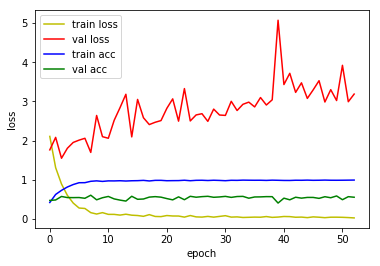

4815/4815 [==============================] - 4s 734us/sample - loss: 1.5867 - acc: 0.5678
Loss: 1.5867312340721536 Accuracy: 0.5678089

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9088 - acc: 0.4246
Epoch 00001: val_loss improved from inf to 1.72218, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_4_conv_checkpoint/001-1.7222.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.9088 - acc: 0.4246 - val_loss: 1.7222 - val_acc: 0.4542
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2780 - acc: 0.6179
Epoch 00002: val_loss improved from 1.72218 to 1.21497, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_4_conv_checkpoint/002-1.2150.hdf5
36805/36805 [==============================] - 80s 2ms/sample - loss: 1.2782 - acc: 0.6179 - val_loss: 1.2150 - val_acc: 0.6471
Epoch 3/500
36800/36805 [============================>.] 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0843 - acc: 0.9811
Epoch 00028: val_loss did not improve from 0.87788
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0845 - acc: 0.9810 - val_loss: 1.2283 - val_acc: 0.7540
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9816
Epoch 00029: val_loss did not improve from 0.87788
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0842 - acc: 0.9816 - val_loss: 1.0507 - val_acc: 0.7666
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9924
Epoch 00030: val_loss did not improve from 0.87788
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0475 - acc: 0.9924 - val_loss: 1.0444 - val_acc: 0.7708
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9891
Epoch 00031: val_loss did not improve from 0.87788
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9956
Epoch 00058: val_loss did not improve from 0.87788
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0297 - acc: 0.9956 - val_loss: 1.8826 - val_acc: 0.6688
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.9890
Epoch 00059: val_loss did not improve from 0.87788
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0521 - acc: 0.9890 - val_loss: 1.2338 - val_acc: 0.7624
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9947
Epoch 00060: val_loss did not improve from 0.87788
36805/36805 [==============================] - 80s 2ms/sample - loss: 0.0295 - acc: 0.9947 - val_loss: 1.3133 - val_acc: 0.7456

1D_CNN_custom_kernel_192_ch_32_BN_4_conv Model


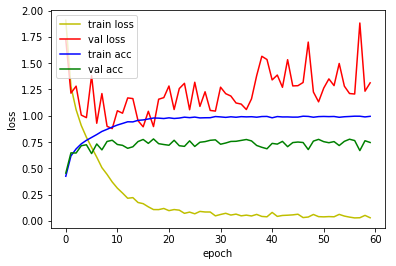

4815/4815 [==============================] - 4s 756us/sample - loss: 0.9795 - acc: 0.7329
Loss: 0.9794765542353178 Accuracy: 0.73291796

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8167 - acc: 0.4380
Epoch 00001: val_loss improved from inf to 1.57099, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_5_conv_checkpoint/001-1.5710.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.8168 - acc: 0.4380 - val_loss: 1.5710 - val_acc: 0.4994
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2309 - acc: 0.6243
Epoch 00002: val_loss improved from 1.57099 to 1.35663, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_5_conv_checkpoint/002-1.3566.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.2308 - acc: 0.6243 - val_loss: 1.3566 - val_acc: 0.5749
Epoch 3/500
36800/36805 [============================>.]

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9761
Epoch 00027: val_loss did not improve from 0.58026
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0931 - acc: 0.9760 - val_loss: 0.6512 - val_acc: 0.8416
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9764
Epoch 00028: val_loss did not improve from 0.58026
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0926 - acc: 0.9763 - val_loss: 1.0024 - val_acc: 0.7766
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9833
Epoch 00029: val_loss did not improve from 0.58026
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0712 - acc: 0.9833 - val_loss: 0.6929 - val_acc: 0.8425
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0772 - acc: 0.9799
Epoch 00030: val_loss did not improve from 0.58026
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9947
Epoch 00057: val_loss did not improve from 0.58026
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0262 - acc: 0.9947 - val_loss: 0.7050 - val_acc: 0.8544
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9952
Epoch 00058: val_loss did not improve from 0.58026
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0272 - acc: 0.9951 - val_loss: 0.7713 - val_acc: 0.8481
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9926
Epoch 00059: val_loss did not improve from 0.58026
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.0325 - acc: 0.9925 - val_loss: 0.6853 - val_acc: 0.8558
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9912
Epoch 00060: val_loss did not improve from 0.58026
36805/36805 [===========

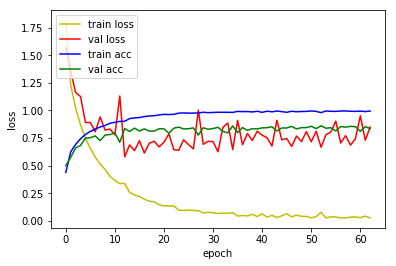

4815/4815 [==============================] - 4s 814us/sample - loss: 0.6947 - acc: 0.8042
Loss: 0.694693348836057 Accuracy: 0.8041537

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9924 - acc: 0.3833
Epoch 00001: val_loss improved from inf to 1.58567, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_6_conv_checkpoint/001-1.5857.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.9923 - acc: 0.3833 - val_loss: 1.5857 - val_acc: 0.5008
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2985 - acc: 0.6011
Epoch 00002: val_loss improved from 1.58567 to 1.10282, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_32_BN_6_conv_checkpoint/002-1.1028.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.2985 - acc: 0.6011 - val_loss: 1.1028 - val_acc: 0.6622
Epoch 3/500
36800/36805 [============================>.] -

In [ ]:
for i in range(3, 10):
    base = '1D_CNN_custom_kernel_192_ch_32_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_BN_2(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [19]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_ch_32_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_50 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.6947 - acc: 0.8042
Loss: 0.694693348836057 Accuracy: 0.8041537

1D_CNN_custom_kernel_192_ch_32_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_64 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_65 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activation)  

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2999 - acc: 0.9115
Loss: 0.2998728373928357 Accuracy: 0.9115265

1D_CNN_custom_kernel_192_ch_32_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         6176      
_________________________________________________________________
batch_normalization_v1_79 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         98336     
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activation) 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2076 - acc: 0.9466
Loss: 0.20758289302295985 Accuracy: 0.9466251
